<a href="https://colab.research.google.com/github/Naimish240/Megha/blob/main/Megha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Megha**
A CNN for ground based cloud classification and weather forecating.
***
By : [Naimish Mani B](https://www.github.com/Naimish240)
***

# **Table Of Contents**
1. Download the Dataset into Colab
2. Pre Processing
3. Building the Model
4. Training the Model
5. Testing the Model
6. Exporting the Model to tflite

#**Downloading the Dataset**
The dataset was procured from [Harvard DataVerse](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/CADDPD) and uploaded to [my Google Drive](https://drive.google.com/file/d/1oC73P4BAl2fkcu4tETL7NpQlKWlvZe8O/view?usp=sharing) for easy access in colab.

In [1]:
# Download the Dataset
!gdown --id 1oC73P4BAl2fkcu4tETL7NpQlKWlvZe8O
# Extract the Images
!tar -xzvf  'CloudDataset.tar.gz'
# Delete the Tarfile
!rm 'CloudDataset.tar.gz'

Streaming output truncated to the last 5000 lines.
Cloud Images/._As-N046.jpg
Cloud Images/As-N046.jpg
Cloud Images/._Sc-N166.jpg
Cloud Images/Sc-N166.jpg
Cloud Images/._Cs-N159.jpg
Cloud Images/Cs-N159.jpg
Cloud Images/._Sc-N172.jpg
Cloud Images/Sc-N172.jpg
Cloud Images/._As-N052.jpg
Cloud Images/As-N052.jpg
Cloud Images/._St-N126.jpg
Cloud Images/St-N126.jpg
Cloud Images/._Cs-N165.jpg
Cloud Images/Cs-N165.jpg
Cloud Images/._Ns-N199.jpg
Cloud Images/Ns-N199.jpg
Cloud Images/._Cs-N171.jpg
Cloud Images/Cs-N171.jpg
Cloud Images/._St-N132.jpg
Cloud Images/St-N132.jpg
Cloud Images/._Cc-N197.jpg
Cloud Images/Cc-N197.jpg
Cloud Images/._Ci-N037.jpg
Cloud Images/Ci-N037.jpg
Cloud Images/._Ac-N088.jpg
Cloud Images/Ac-N088.jpg
Cloud Images/._Cb-N183.jpg
Cloud Images/Cb-N183.jpg
Cloud Images/._Cb-N197.jpg
Cloud Images/Cb-N197.jpg
Cloud Images/._Cc-N183.jpg
Cloud Images/Cc-N183.jpg
Cloud Images/._Ci-N023.jpg
Cloud Images/Ci-N023.jpg
Cloud Images/._Cu-N100.jpg
Cloud Images/Cu-N100.jpg
Cloud Images/

Check if images downloaded properly

In [2]:
import glob
!ls

'Cloud Images'	 sample_data


Get list of all images into memory.

In [3]:
IMAGE_PATHS = glob.glob('Cloud Images/*.jpg')

# Print statements to check if it's working properly
print(len(IMAGE_PATHS))
IMAGE_PATHS[:5]

2543


['Cloud Images/Cb-N084.jpg',
 'Cloud Images/Ct-N061.jpg',
 'Cloud Images/Ct-N177.jpg',
 'Cloud Images/Ac-N192.jpg',
 'Cloud Images/St-N008.jpg']

In [4]:
IMAGE_PATHS[0][13:15]

'Cb'

# **Pre Processing**

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
from skimage.transform import resize
import random

random.seed(69)

# Shuffle images here itself, for sanity reasons
random.shuffle(IMAGE_PATHS)

Load a random image and display it

Cloud Images/Sc-N154.jpg


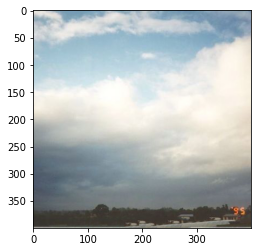

In [6]:
img_path = random.choice(IMAGE_PATHS)
print(img_path)

img = plt.imread(img_path)
plt.imshow(img)

In [7]:
def img_to_pil(img_path):
  '''
    Input:
      img_path : path to image on disk

    Output:
      img : PIL image object
  '''
  img = PIL.Image.open(img_path)
  return img

def img_to_numpy_array(img):
  '''
  Input:
    img : PIL object

  Output:
    Numpy Array of image
  '''
  return np.array(img)

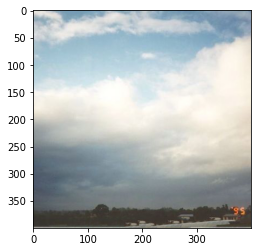

In [9]:
# Gets image to numpy
img = img_to_pil(img_path)
img = img_to_numpy_array(img)
# Shows image
plt.imshow(img)

## **Get Labels from images**


In [10]:
CATEGORIES = ["Ci", "Cs", "Cc", "Ac", "As", "Cu", "Cb", "Ns", "Sc", "St", "Ct"]

y = []

for image in IMAGE_PATHS:
  image_category = image[13:15]
  y.append(CATEGORIES.index(image_category))

# Check if it worked properly
print(IMAGE_PATHS[0])
print(y[0])

Cloud Images/Sc-N005.jpg
8


***
## **Augment Images**

Currently, the dataset contains :

- Cirrus        (139 images)
- Cirrostratus  (287 images)
- Cirrocumulus  (268 images)
- Altocumulus   (221 images)
- Altostratus   (188 images)
- Cumulus       (182 images)
- Cumulonimbus  (242 images)
- Nimbostratus  (274 images)
- Stratocumulus (340 images)
- Stratus       (202 images)
- Contrails     (200 images)
Total :         2543 images

To balance the dataset, we'll assume that we need 350 images in each class (since max + 10)

So, extending this, each class requires
- Cirrus        (211 images)
- Cirrostratus  (063 images)
- Cirrocumulus  (082 images)
- Altocumulus   (129 images)
- Altostratus   (162 images)
- Cumulus       (168 images)
- Cumulonimbus  (108 images)
- Nimbostratus  (076 images)
- Stratocumulus (010 images)
- Stratus       (148 images)
- Contrails     (150 images)
Total :         3850 images

###**Note**:

*Since all we're doing is looking for patterns and not features, we're assuming that augmenting a class to
more than double the images it initially started off with won't have a serious impact on the final results.
This may/may not be a valid assumption, though. We'll only know for sure after training.
Also, since all we're looking for is a pattern, rotation and flipping don't make much sense. Same goes for adding noise and blurring. And given how some images have buildings in the bottom, translating is also risky.
Hence, we're only cropping or resizing the images.*
***


In [16]:
# Function to crop image array
def cropImg(x, y, arr):
  return arr[x:x+NEW_IMAGE_SIZE, y:y+NEW_IMAGE_SIZE]

# Function to augment images and get feature set
def augmented_images():
  # Features set
  features = []
  # Labels set
  labels = []

  # Iterate through all images in the dataset to make the train set
  for i in range(len(IMAGE_PATHS)):

    # If we don't need to augment any more images of that class
    if not augmentable_count[y[i]] > 0:
      continue

    # Reduce augmentable image count by 1
    augmentable_count[y[i]] -= 1

    # Get Numpy array of image in grayscale mode
    img_arr = img_to_numpy_array(img_to_pil(IMAGE_PATHS[i]))
    
    '''
    if img_arr.shape == (256, 256, 3):
      
      continue
    # print(img_arr.shape)
    '''
    OLD_IMAGE_SIZE = img_arr.shape[0]

    # Get coordinates to crop into
    x_coordinate = random.randint(0, OLD_IMAGE_SIZE - NEW_IMAGE_SIZE - 1)
    y_coordinate = random.randint(0, OLD_IMAGE_SIZE - NEW_IMAGE_SIZE - 1)

    # Crop image
    new_img = cropImg(x_coordinate, y_coordinate, img_arr)
    #print(new_img.shape)

    # Add it to the features set
    features.append(img_to_numpy_array(new_img))

    labels.append(y[i])

  # Return Features set
  return features, labels

def resized_images():
  features = []
  labels = []

  for i in range(len(IMAGE_PATHS)):
    # Get image array
    img_arr = img_to_numpy_array(img_to_pil(IMAGE_PATHS[i]))
    #print(img_arr.shape)

    '''
    if img_arr.shape == (256, 256, 3):
      features.append(img_arr)
      labels.append(y[i])
      continue
    '''

    res = resize(img_arr, (128, 128, 3))
    #print(res.shape)
    
    features.append(res)
    #print(i)
    labels.append(y[i])

  return features, labels

# Set image dimensions
NEW_IMAGE_SIZE = 128

# Count of number of images that can be augmented per class
augmentable_count = {
    0  : 211,
    1  :  63,
    2  :  82,
    3  : 129,
    4  : 162,
    5  : 168,
    6  : 108,
    7  :  76,
    8  :  10,
    9  : 148,
    10 : 150
}

###**Crop Images**

1235 1235
(128, 128, 3)


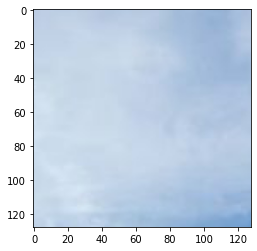

In [17]:
x_aug, y_aug = augmented_images()
print(len(x_aug), len(y_aug))
print(x_aug[0].shape)

img = random.choice(x_aug)
plt.imshow(img)

###**Resize Images**

2543 2543
(128, 128, 3)


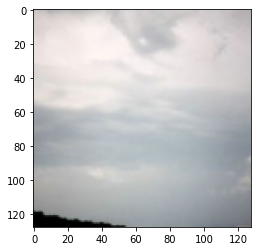

In [18]:
x_res, y_res = resized_images()
print(len(x_res), len(y_res))
print(x_res[0].shape)

img = random.choice(x_res)
plt.imshow(img)

##**Merge into single dataset**

In [23]:
x = x_res + x_aug
y = y_res + y_aug

print(x[2556].shape)

x = np.array(x)
print(x.shape)

y = np.stack(y, axis=0)
print(y.shape)

print(len(x))
print(len(y))

x /= 255

(128, 128, 3)
(3778, 128, 128, 3)
(3778,)
3778
3778


In [ ]:
# Delete old stuff to prevent mem leaks
del x_res
del x_aug
del y_res
del y_aug
del img
del IMAGE_PATHS

As you can see, we wanted 3850 images, but augmentation only got us 3778 images. Which is good enough for the classifier.

Before we move ahead, let's randomly plot a few images to see the results of the augmentation.

(128, 128, 3)


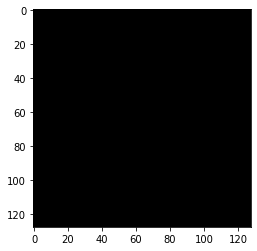

In [24]:
# Makes sense, since scaled down by 255
img = x[0]
print(x[0].shape)
plt.imshow(img)

#**Build the Model**

In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

##**Test Train Split**

In [26]:
x_train = x[:-250]
x_test = x[-250:]
y_train = y[:-250]
y_test = y[-250:]

# Print shapes to ensure things are as expected
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

# Delete to prevent memory leaks
del x
del y

(3528, 128, 128, 3)
(250, 128, 128, 3)
(3528,)
(250,)


##**Build the Model**

In [38]:
# Create the Model
num_classes = 11

model = keras.Sequential()

model.add(keras.Input(shape=(128, 128, 3)))

# Add First Conv Layer
model.add(layers.Conv2D(
    filters=64, 
    kernel_size=5, 
    strides=(3,3), 
    activation='relu',
))


# Do some BatchNorm
model.add(keras.layers.BatchNormalization())
# Throw in a Max Pooling layer
model.add(layers.MaxPooling2D(
    pool_size=(3,3)
))

# Add second Conv Layer
model.add(layers.Conv2D(
    filters=224, 
    kernel_size=(3,3), 
    strides=(1,1), 
    activation='relu', 
    padding="same"
))
          
# Do some BatchNorm
model.add(keras.layers.BatchNormalization())

# Add another Conv2D layer
model.add(layers.Conv2D(
    filters=96,
    kernel_size=(3,3),
    strides=(1,1),
    activation='relu',
    padding='same'
))

# Add another Conv2D layer
model.add(layers.Conv2D(
    filters=32,
    kernel_size=(3,3),
    strides=(1,1),
    activation='relu',
    padding='same'
))

# MaxPool layer
model.add(layers.MaxPooling2D(
    pool_size=(1,1)
))

# Time to go Flat
model.add(layers.Flatten())

# Add a Dense layer
model.add(layers.Dense(320, 'relu'))
# One Final Dropout
model.add(layers.Dropout(0.5))
# Output Layer
model.add(layers.Dense(11, 'softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Build model
model.build()

# Model Summary
model.summary()


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 42, 42, 64)        4864      
_________________________________________________________________
batch_normalization_19 (Batc (None, 42, 42, 64)        256       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 14, 14, 224)       129248    
_________________________________________________________________
batch_normalization_20 (Batc (None, 14, 14, 224)       896       
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 14, 14, 96)        193632    
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 14, 14, 32)       

In [39]:
# Train
epochs = 45
history = model.fit(
    x_train, 
    y_train, 
    batch_size=32,
    epochs=epochs
)

Epoch 1/45
111/111 [==============================] - 49s 438ms/step - loss: 2.7778 - accuracy: 0.1091
Epoch 2/45
111/111 [==============================] - 48s 436ms/step - loss: 2.3556 - accuracy: 0.1412
Epoch 3/45
111/111 [==============================] - 49s 437ms/step - loss: 2.3377 - accuracy: 0.1593
Epoch 4/45
111/111 [==============================] - 48s 436ms/step - loss: 2.2693 - accuracy: 0.1936
Epoch 5/45
111/111 [==============================] - 48s 436ms/step - loss: 2.2357 - accuracy: 0.2026
Epoch 6/45
111/111 [==============================] - 48s 434ms/step - loss: 2.2213 - accuracy: 0.2015
Epoch 7/45
111/111 [==============================] - 48s 433ms/step - loss: 2.2231 - accuracy: 0.2037
Epoch 8/45
111/111 [==============================] - 48s 433ms/step - loss: 2.2322 - accuracy: 0.2024
Epoch 9/45
111/111 [==============================] - 48s 434ms/step - loss: 2.2104 - accuracy: 0.2166
Epoch 10/45
111/111 [==============================] - 48s 435ms/step - l

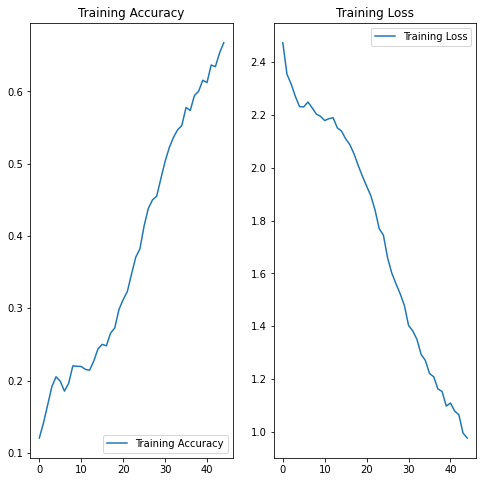

In [40]:
# Analysis, of first training part
acc = history.history['accuracy']

loss = history.history['loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()

In [41]:
# Train
epochs = 10
history = model.fit(
    x_train, 
    y_train, 
    batch_size=32,
    epochs=epochs
)

Epoch 1/10
111/111 [==============================] - 48s 435ms/step - loss: 0.9626 - accuracy: 0.6715
Epoch 2/10
111/111 [==============================] - 48s 433ms/step - loss: 0.9791 - accuracy: 0.6627
Epoch 3/10
111/111 [==============================] - 48s 435ms/step - loss: 0.9629 - accuracy: 0.6650
Epoch 4/10
111/111 [==============================] - 48s 433ms/step - loss: 0.9317 - accuracy: 0.6840
Epoch 5/10
111/111 [==============================] - 48s 432ms/step - loss: 0.9070 - accuracy: 0.6786
Epoch 6/10
111/111 [==============================] - 48s 432ms/step - loss: 0.9254 - accuracy: 0.6817
Epoch 7/10
111/111 [==============================] - 48s 433ms/step - loss: 0.8955 - accuracy: 0.6936
Epoch 8/10
111/111 [==============================] - 48s 433ms/step - loss: 0.8994 - accuracy: 0.6947
Epoch 9/10
111/111 [==============================] - 48s 436ms/step - loss: 0.8624 - accuracy: 0.6995
Epoch 10/10
111/111 [==============================] - 48s 435ms/step - l

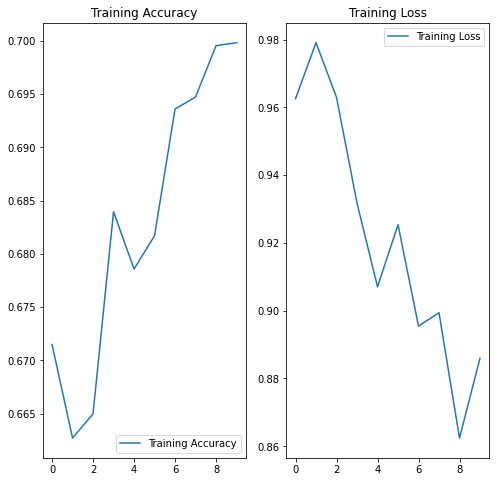

In [42]:
# Analysis
acc = history.history['accuracy']

loss = history.history['loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()

Yeah, since the model didn't improve much during these 10 epochs, there's a very high probability that the model will start overfitting after this. So, we quit while we're ahead and move on to exporting this model.

In [52]:
model.save('.')

INFO:tensorflow:Assets written to: ./assets


In [56]:
converter = tf.lite.TFLiteConverter.from_saved_model('.')
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [57]:
!ls

 assets      'Cloud Images'   sample_data      variables
 checkpoint   model.tflite    saved_model.pb


In [59]:
from google.colab import files
files.download("model.tflite")
files.download("saved_model.pb")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>